# **DrQA**

This notebook implements the DrQA model. Specifically, DrQA is an end-to-end system for open domain question answering which involves an information retrieval system as well. This notebook however only explains the deep learning model to predict the span of answers.


In [ ]:
import gzip
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
import pickle
import collections
from pandas.io.json import json_normalize
import torch
from torch import nn
import re, os, string, typing, gc, json
import spacy
from collections import Counter
nlp = spacy.load('en_core_web_sm')


Importing necessary Libraries

In [ ]:
!pip install nltk
!pip install torch==1.0.0
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install pandas

**Preprocessing**

Following are the major steps involved in the pipeline.


1.   Load the dataset files 2 JSON files.
2.   Parse the JSON files to get the data in the desired format.
3.   Filter large examples: Based on sequence lengths, drop some of the outliers.
4.   Gather text to build vocabularies. Vocabularies in NLP are just a mapping from words to integers. The integers then represent that word and are subsequently converted into word embeddings.
5.   For each example in the dataset, map the word to its corresponding id. This process is also known as numericalization of text.










In [ ]:
def load_json(path):
    '''
    Loads the JSON file of the Squad dataset.
    Returns the json object of the dataset.
    '''
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        
    print("Length of data: ", len(data['data']))
   
    return data

In [ ]:
# load dataset json files

train_data = load_json('coqa-train-v1.0.json')
valid_data = load_json('coqa-dev-v1.0.json')

Length of data:  7199
Length of data:  500


In [ ]:
data=json.load((open('coqa-train-v1.0.json')))
qas=json_normalize(data['data'], ['questions'],['source','id','story'])
ans=json_normalize(data['data'], ['answers'],['id'])
df1 = pd.merge(qas,ans, left_on=['id','turn_id'],right_on=['id','turn_id'] )
df1['id'] = df1.apply(lambda row: row.id + str(row.turn_id), axis=1)
df1['label'] = df1.apply(lambda row: [row.span_start] + [row.span_end], axis=1)
train_df=df1[['id', 'story','input_text_x','label','span_text']]
train_df.rename({'story': 'context', 'input_text_x': 'question','span_text':'answer'}, axis=1, inplace=True)
train_df.head()

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,id,context,question,label,answer
0,3zotghdk5ibi9cex97fepx7jetpso71,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,"[151, 179]",Formally established in 1475
1,3zotghdk5ibi9cex97fepx7jetpso72,"The Vatican Apostolic Library (), more commonl...",what is the library for?,"[454, 494]",he Vatican Library is a research library
2,3zotghdk5ibi9cex97fepx7jetpso73,"The Vatican Apostolic Library (), more commonl...",for what subjects?,"[457, 511]",Vatican Library is a research library for hist...
3,3zotghdk5ibi9cex97fepx7jetpso74,"The Vatican Apostolic Library (), more commonl...",and?,"[457, 545]",Vatican Library is a research library for hist...
4,3zotghdk5ibi9cex97fepx7jetpso75,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,"[769, 879]","March 2014, the Vatican Library began an initi..."


In [ ]:
data=json.load(open('coqa-dev-v1.0.json'))
qas=json_normalize(data['data'], ['questions'],['source','id','story'])
ans=json_normalize(data['data'], ['answers'],['id'])
df1 = pd.merge(qas,ans, left_on=['id','turn_id'],right_on=['id','turn_id'] )
df1['id'] = df1.apply(lambda row: row.id + str(row.turn_id), axis=1)
df1['label'] = df1.apply(lambda row: [row.span_start] + [row.span_end], axis=1)
valid_df=df1[['id', 'story','input_text_x','label','span_text']]
valid_df.rename({'story': 'context', 'input_text_x': 'question','span_text':'answer'}, axis=1, inplace=True)
valid_df.head()

,id,context,question,label,answer
0,3dr23u6we5exclen4th8uq9rb42tel1,"Once upon a time, in a barn near a farm house,...",What color was Cotton?,"[59, 93]",a little white kitten named Cotton
1,3dr23u6we5exclen4th8uq9rb42tel2,"Once upon a time, in a barn near a farm house,...",Where did she live?,"[18, 80]","in a barn near a farm house, there lived a lit..."
2,3dr23u6we5exclen4th8uq9rb42tel3,"Once upon a time, in a barn near a farm house,...",Did she live alone?,"[196, 215]",Cotton wasn't alone
3,3dr23u6we5exclen4th8uq9rb42tel4,"Once upon a time, in a barn near a farm house,...",Who did she live with?,"[281, 315]",with her mommy and 5 other sisters
4,3dr23u6we5exclen4th8uq9rb42tel5,"Once upon a time, in a barn near a farm house,...",What color were her sisters?,"[428, 490]",her sisters were all orange with beautiful whi...


In [ ]:
def normalize_spaces(text):
    '''
    Removes extra white spaces from the context.
    '''
    text = re.sub(r'\s', ' ', text)
    return text

train_df.context = train_df.context.apply(normalize_spaces)
valid_df.context = valid_df.context.apply(normalize_spaces)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
def gather_text_for_vocab(dfs:list):
    '''
    Gathers text from contexts and questions to build a vocabulary.
    '''
    
    text = []
    total = 0
    for df in dfs:
        unique_contexts = list(df.context.unique())
        unique_questions = list(df.question.unique())
        total += df.context.nunique() + df.question.nunique()
        text.extend(unique_contexts + unique_questions)
    
    assert len(text) == total
    
    return text
    
# gather text to build vocabularies

%time vocab_text = gather_text_for_vocab([train_df, valid_df])
print("Number of sentences in dataset: ", len(vocab_text))

CPU times: user 537 ms, sys: 11 ms, total: 548 ms
Wall time: 546 ms
Number of sentences in dataset:  102126


In [ ]:
def build_word_vocab(vocab_text):
    '''
    Builds a word-level vocabulary from the given text.
    
    :param list vocab_text: list of contexts and questions
    :returns 
        dict word2idx: word to index mapping of words
        dict idx2word: integer to word mapping
        list word_vocab: list of words sorted by frequency
    '''
    
    
    words = []
    for sent in vocab_text:
        for word in nlp(sent, disable=['parser','tagger','ner']):
            words.append(word.text)

    word_counter = Counter(words)
    word_vocab = sorted(word_counter, key=word_counter.get, reverse=True)
    print(f"raw-vocab: {len(word_vocab)}")
    #word_vocab = list(set(word_vocab).intersection(set(glove_words)))
    print(f"glove-vocab: {len(word_vocab)}")
    word_vocab.insert(0, '<unk>')
    word_vocab.insert(1, '<pad>')
    print(f"vocab-length: {len(word_vocab)}")
    word2idx = {word:idx for idx, word in enumerate(word_vocab)}
    print(f"word2idx-length: {len(word2idx)}")
    idx2word = {v:k for k,v in word2idx.items()}
    
    
    return word2idx, idx2word, word_vocab

# build word vocabulary

%time word2idx, idx2word, word_vocab = build_word_vocab(vocab_text)

raw-vocab: 79815
glove-vocab: 79815
vocab-length: 79817
word2idx-length: 79817
CPU times: user 56.7 s, sys: 181 ms, total: 56.9 s
Wall time: 56.9 s


In [ ]:
def build_char_vocab(vocab_text):
    '''
    Builds a character-level vocabulary from the given text.
    
    :param list vocab_text: list of contexts and questions
    :returns 
        dict char2idx: character to index mapping of words
        list char_vocab: list of characters sorted by frequency
    '''
    
    chars = []
    for sent in vocab_text:
        for ch in sent:
            chars.append(ch)

    char_counter = Counter(chars)
    char_vocab = sorted(char_counter, key=char_counter.get, reverse=True)
    print(f"raw-char-vocab: {len(char_vocab)}")
    high_freq_char = [char for char, count in char_counter.items() if count>=20]
    char_vocab = list(set(char_vocab).intersection(set(high_freq_char)))
    print(f"char-vocab-intersect: {len(char_vocab)}")
    char_vocab.insert(0,'<unk>')
    char_vocab.insert(1,'<pad>')
    char2idx = {char:idx for idx, char in enumerate(char_vocab)}
    print(f"char2idx-length: {len(char2idx)}")
    
    return char2idx, char_vocab

In [ ]:
def context_to_ids(text, word2idx):
    '''
    Converts context text to their respective ids by mapping each word
    using word2idx. Input text is tokenized using spacy tokenizer first.
    
    :param str text: context text to be converted
    :returns list context_ids: list of mapped ids
    
    :raises assertion error: sanity check
    
    '''

    context_tokens = [w.text for w in nlp(text, disable=['parser','tagger','ner'])]
    context_ids = [word2idx[word] for word in context_tokens]
    
    assert len(context_ids) == len(context_tokens)
    return context_ids
    
def question_to_ids(text, word2idx):
    '''
    Converts question text to their respective ids by mapping each word
    using word2idx. Input text is tokenized using spacy tokenizer first.
    
    :param str text: question text to be converted
    :returns list context_ids: list of mapped ids
    
    :raises assertion error: sanity check
    
    '''

    question_tokens = [w.text for w in nlp(text, disable=['parser','tagger','ner'])]
    question_ids = [word2idx[word] for word in question_tokens]
    
    assert len(question_ids) == len(question_tokens)
    return question_ids

In [ ]:
# numericalize context and questions for training and validation set


%time train_df['context_ids'] = train_df.context.apply(context_to_ids, word2idx=word2idx)
%time valid_df['context_ids'] = valid_df.context.apply(context_to_ids, word2idx=word2idx)

%time train_df['question_ids'] = train_df.question.apply(question_to_ids,  word2idx=word2idx)
%time valid_df['question_ids'] = valid_df.question.apply(question_to_ids,  word2idx=word2idx)

CPU times: user 5min 18s, sys: 253 ms, total: 5min 18s
Wall time: 5min 18s


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


CPU times: user 22.4 s, sys: 28 ms, total: 22.4 s
Wall time: 22.4 s
CPU times: user 40.7 s, sys: 7.94 ms, total: 40.7 s
Wall time: 40.7 s
CPU times: user 3 s, sys: 0 ns, total: 3 s
Wall time: 3 s


Purpose behind this test was to ensure that the label for each example was correct. Two ways to test this.

First is to calculate spans of the context and check if start and end indices from the label are present in the calculated spans. Index value of the example which fails the start and end tests are appended in separate lists.

Second is to get the start and end indices of the answer in the context_ids list. Get the ids corresponding to those positions, convert them to string using word2idx and compare them with the start and end tokens from the given answer. 

Examples which fail this test have their position added to a list.
The reason why some examples fail here is largely due to the absence of a ' ' or a space before and after the answer in the context. There are some spans that the tokenizer fails to capture or is simply a case where the example is not cleaned.


In [ ]:
def test_indices(df, idx2word):
    '''
    Performs the tests mentioned above. This method also gets the start and end of the answers
    with respect to the context_ids for each example.
    
    :param dataframe df: SQUAD df
    :returns
        list start_value_error: example idx where the start idx is not found in the start spans
                                of the text
        list end_value_error: example idx where the end idx is not found in the end spans
                              of the text
        list assert_error: examples that fail assertion errors. A majority are due to the above errors
        
    '''

    start_value_error = []
    end_value_error = []
    assert_error = []
    for index, row in df.iterrows():

        answer_tokens = [w.text for w in nlp(row['answer'], disable=['parser','tagger','ner'])]

        start_token = answer_tokens[0]
        end_token = answer_tokens[-1]
        
        context_span  = [(word.idx, word.idx + len(word.text)) 
                         for word in nlp(row['context'], disable=['parser','tagger','ner'])]

        starts, ends = zip(*context_span)

        answer_start, answer_end = row['label']

        try:
            start_idx = starts.index(answer_start)
        except:
            start_value_error.append(index)
        try:
            end_idx  = ends.index(answer_end)
        except:
            end_value_error.append(index)

        try:
            assert idx2word[row['context_ids'][start_idx]] == answer_tokens[0]
            assert idx2word[row['context_ids'][end_idx]] == answer_tokens[-1]
        except:
            assert_error.append(index)


    return start_value_error, end_value_error, assert_error

In [ ]:
def get_error_indices(df, idx2word):
    '''
    Gets error indices from the method above and returns a 
    set of those indices.
    '''
    
    start_value_error, end_value_error, assert_error = test_indices(df,idx2word)
    err_idx = start_value_error + end_value_error + assert_error
    err_idx = set(err_idx)
    print(f"Error indices: {len(err_idx)}")
    
    return err_idx

In [ ]:
def index_answer(row, idx2word):
    '''
    Takes in a row of the dataframe or one training example and
    returns a tuple of start and end positions of answer by calculating 
    spans.
    '''
    
    context_span = [(word.idx, word.idx + len(word.text)) for word in nlp(row.context, disable=['parser','tagger','ner'])]
    starts, ends = zip(*context_span)
    
    answer_start, answer_end = row.label
    start_idx = starts.index(answer_start)
 
    end_idx  = ends.index(answer_end)
    
    ans_toks = [w.text for w in nlp(row.answer,disable=['parser','tagger','ner'])]
    ans_start = ans_toks[0]
    ans_end = ans_toks[-1]
    assert idx2word[row.context_ids[start_idx]] == ans_start
    assert idx2word[row.context_ids[end_idx]] == ans_end
    
    return [start_idx, end_idx]

In [ ]:
# get indices with tokenization errors and drop those indices 

train_err = get_error_indices(train_df, idx2word)
valid_err = get_error_indices(valid_df, idx2word)

train_df.drop(train_err, inplace=True)
#valid_df.drop(valid_err, inplace=True)

Error indices: 39932
Error indices: 2786


In [ ]:
valid_df.drop(valid_err, inplace=True)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# get start and end positions of answers from the context
# this is basically the label for training QA models

train_label_idx = train_df.apply(index_answer, axis=1, idx2word=idx2word)
valid_label_idx = valid_df.apply(index_answer, axis=1, idx2word=idx2word)

train_df['label_idx'] = train_label_idx
valid_df['label_idx'] = valid_label_idx

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train_df['label_idx'] = train_label_idx

**Dump data to pickle files**

This ensures that we can directly access the preprocessed dataframe next time.


In [ ]:
import pickle
with open('drqastoi.pickle','wb') as handle:
    pickle.dump(word2idx, handle)
    
train_df.to_pickle('drqatrain1.pkl')
valid_df.to_pickle('drqavalid1.pkl')

**Read data from pickle files**

We only need to run the preprocessing once. Some preprocessing functions can take upto 150 mins since our dataset is very large. Therefore, pickling preprocessed data can save a lot of time. Once the preprocessed files are saved, we can directly start from here.


In [ ]:
train_df = pd.read_pickle('drqatrain1.pkl')
valid_df = pd.read_pickle('drqavalid1.pkl')

In [ ]:
train_df.head()

,id,context,question,label,answer,context_ids,question_ids,label_idx
0,3zotghdk5ibi9cex97fepx7jetpso71,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,"[151, 179]",Formally established in 1475,"[29, 7409, 15677, 2914, 55, 53, 3, 86, 1430, 1...","[81, 12, 2, 23438, 3772, 695, 5]","[31, 34]"
2,3zotghdk5ibi9cex97fepx7jetpso73,"The Vatican Apostolic Library (), more commonl...",for what subjects?,"[457, 511]",Vatican Library is a research library for hist...,"[29, 7409, 15677, 2914, 55, 53, 3, 86, 1430, 1...","[22, 35, 2676, 5]","[88, 97]"
3,3zotghdk5ibi9cex97fepx7jetpso74,"The Vatican Apostolic Library (), more commonl...",and?,"[457, 545]",Vatican Library is a research library for hist...,"[29, 7409, 15677, 2914, 55, 53, 3, 86, 1430, 1...","[8, 5]","[88, 103]"
4,3zotghdk5ibi9cex97fepx7jetpso75,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,"[769, 879]","March 2014, the Vatican Library began an initi...","[29, 7409, 15677, 2914, 55, 53, 3, 86, 1430, 1...","[35, 12, 283, 11, 1301, 5]","[145, 163]"
6,3zotghdk5ibi9cex97fepx7jetpso77,"The Vatican Apostolic Library (), more commonl...",how many?,"[1048, 1128]",Scholars have traditionally divided the histor...,"[29, 7409, 15677, 2914, 55, 53, 3, 86, 1430, 1...","[84, 62, 5]","[196, 207]"



## **Dataset/Dataloader**

In [ ]:
class CoQADataset:
    '''
    -Divides the dataframe in batches.
    -Pads the contexts and questions dynamically for each batch by padding 
     the examples to the maximum-length sequence in that batch.
    -Calculates masks for context and question.
    -Calculates spans for contexts.
    '''
    
    def __init__(self, data, batch_size):
        
        self.batch_size = batch_size
        data = [data[i:i+self.batch_size] for i in range(0, len(data), self.batch_size)]
        self.data = data
    
    def get_span(self, text):
        
        text = nlp(text, disable=['parser','tagger','ner'])
        span = [(w.idx, w.idx+len(w.text)) for w in text]

        return span

    def __len__(self):
        return len(self.data)
    
    def __iter__(self):
        '''
        Creates batches of data and yields them.
        
        Each yield comprises of:
        :padded_context: padded tensor of contexts for each batch 
        :padded_question: padded tensor of questions for each batch 
        :context_mask & question_mask: zero-mask for question and context
        :label: start and end index wrt context_ids
        :context_text,answer_text: used while validation to calculate metrics
        :context_spans: spans of context text
        :ids: question_ids used in evaluation
        '''
        
        for batch in self.data:
                            
            spans = []
            context_text = []
            answer_text = []
            
            max_context_len = max([len(ctx) for ctx in batch.context_ids])
            padded_context = torch.LongTensor(len(batch), max_context_len).fill_(1)
            
            for ctx in batch.context:
                context_text.append(ctx)
                spans.append(self.get_span(ctx))
            
            for ans in batch.answer:
                answer_text.append(ans)
                
            for i, ctx in enumerate(batch.context_ids):
                padded_context[i, :len(ctx)] = torch.LongTensor(ctx)
            
            max_question_len = max([len(ques) for ques in batch.question_ids])
            padded_question = torch.LongTensor(len(batch), max_question_len).fill_(1)
            
            for i, ques in enumerate(batch.question_ids):
                padded_question[i,: len(ques)] = torch.LongTensor(ques)
                
            
            label = torch.LongTensor(list(batch.label_idx))
            context_mask = torch.eq(padded_context, 1)
            question_mask = torch.eq(padded_question, 1)
            
            ids = list(batch.id)  
            
            yield (padded_context, padded_question, context_mask, 
                   question_mask, label, context_text, answer_text, ids)

In [ ]:
train_dataset = CoQADataset(train_df, 32)
valid_dataset = CoQADataset(valid_df, 32)

In [ ]:
a = next(iter(train_dataset))
a[0].shape, a[1].shape, a[2].shape, a[3].shape, a[4].shape

(torch.Size([32, 349]),
 torch.Size([32, 12]),
 torch.Size([32, 349]),
 torch.Size([32, 12]),
 torch.Size([32, 2]))

## **Model**
An input example during training is comprised of



*   a paragraph / context $p$ consisting of $l$ tokens { $p_{1}$, $p_{2}$,..., $p_
{l}$ }
*   a question $q$ consisting of $m$ tokens { $q_{1}$, $q_{2}$,..., $q_{m}$ }
*   a start and and end position that comes from the context itself. More specifically, the start and end indices of the answer from the context






The following flowchart shows the flow of the model.
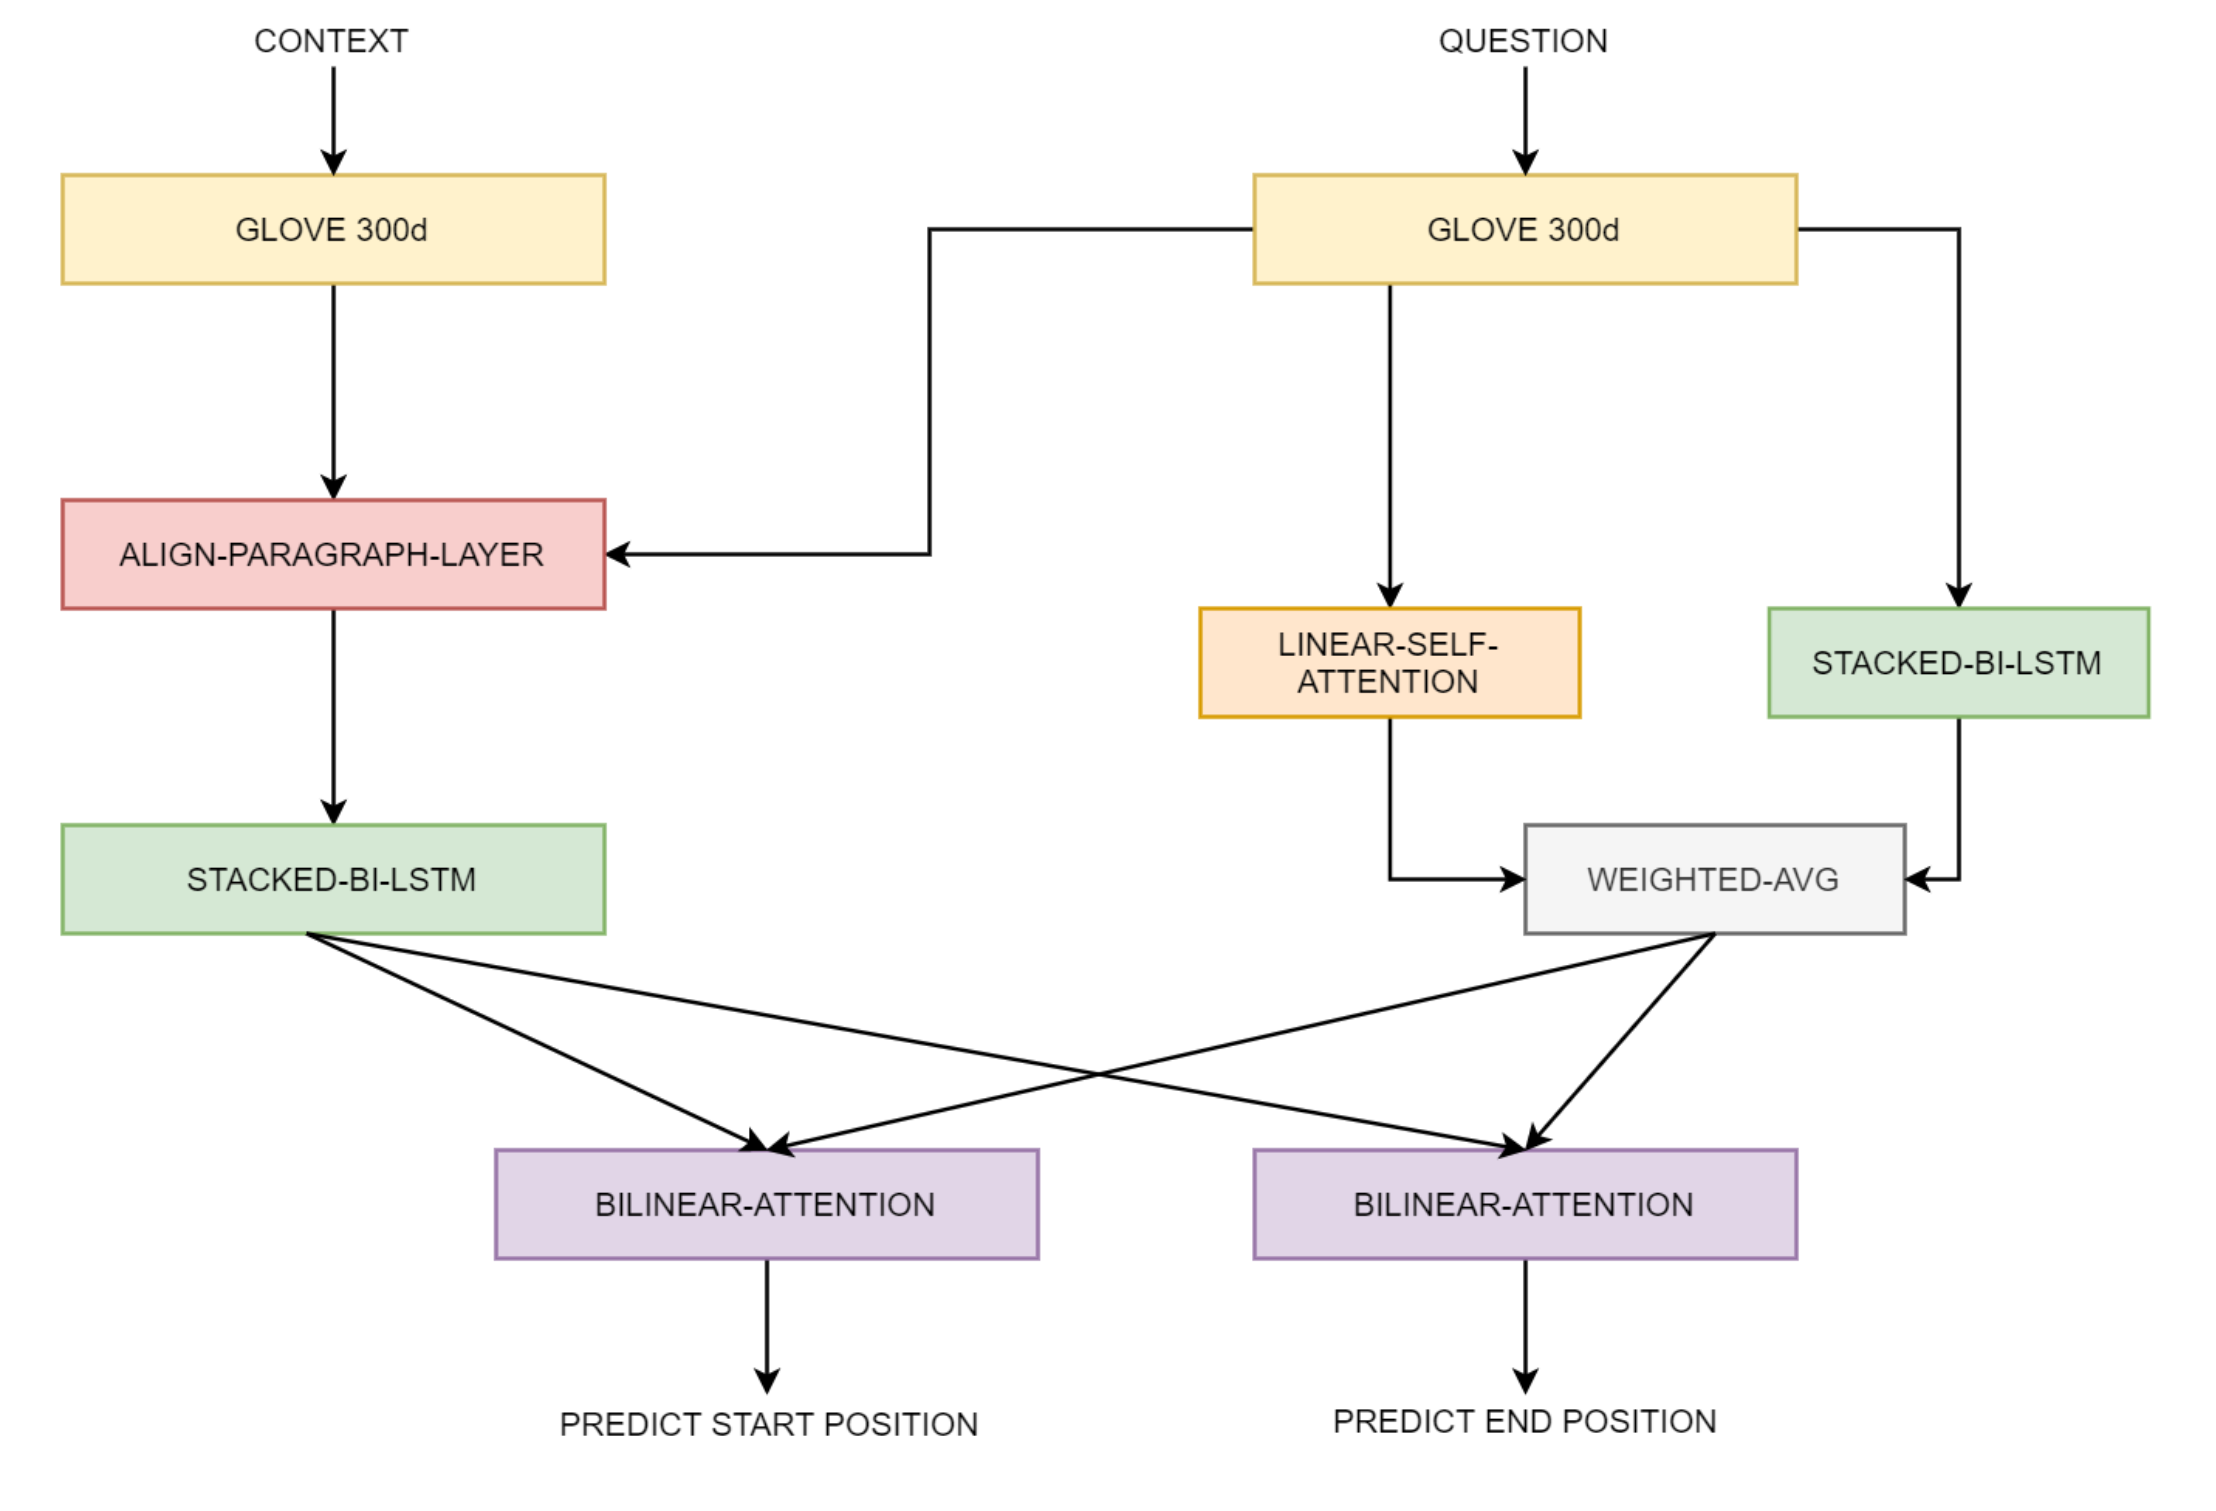

**Word Embedding**

The first transformation for both the question and the context tokens is that they are passed through an embedding layer initialized with pre-trained GloVe word vectors. 

300-dimensional vectors from 840B web crawl version are used here. This version of GLoVe has a vocabulary of 2.2M words. Out of vocabulary or OOV words are initialized by a zero vector. OOV words are the words that are present in your dataset but not in the pretrained vocabulary of GLoVe.

These word vectors are used to project/convert a word into a floating point vector which encodes various features associated with the word into its dimensions. Such a conversion is necassary since computers cannot process words as strings but can seamlessly work with a large number of floating point matrices.

A dot product between vectors of word that are semantically similar is close to 1 and vice-versa.

In [ ]:

def create_glove_matrix():
    '''
    Parses the glove word vectors text file and returns a dictionary with the words as
    keys and their respective pretrained word vectors as values.
    '''
    glove_dict = {}
    with open("glove.6B.300d.txt", "r", encoding="utf-8") as f:
        for line in f:
            values = line.split(' ')
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            glove_dict[word] = vector

    f.close()
    
    return glove_dict

In [ ]:

glove_dict = create_glove_matrix()

In [ ]:
def create_word_embedding(glove_dict):
    '''
    Creates a weight matrix of the words that are common in the GloVe vocab and
    the dataset's vocab. Initializes OOV words with a zero vector.
    '''
    weights_matrix = np.zeros((len(word_vocab), 300))
    words_found = 0
    for i, word in enumerate(word_vocab):
        try:
            weights_matrix[i] = glove_dict[word]
            words_found += 1
        except:
            pass
    return weights_matrix, words_found

In [ ]:
weights_matrix, words_found = create_word_embedding(glove_dict)

In [ ]:
print("Total words found in glove vocab: ", words_found)

Total words found in glove vocab:  36585


In [ ]:
np.save('drqaglove_vt.npy',weights_matrix)


**Align Question Embedding**

This feature enables the model to understand what portion of the context is more important or relevant with respect to the question. The products of projections taken at token level ensure a higher value when similar words from the question and context are multiplied.These features add soft alignments between similar but non-identical words (e.g., car and vehicle).

This is achieved via backpropation and training the weights of the dense layer. 


In [ ]:
class AlignQuestionEmbedding(nn.Module):
    
    def __init__(self, input_dim):        
        
        super().__init__()
        
        self.linear = nn.Linear(input_dim, input_dim)
        
        self.relu = nn.ReLU()
        
    def forward(self, context, question, question_mask):
    
        ctx_ = self.linear(context)
        ctx_ = self.relu(ctx_)
        
        qtn_ = self.linear(question)
        qtn_ = self.relu(qtn_)
        
        qtn_transpose = qtn_.permute(0,2,1)
        
        align_scores = torch.bmm(ctx_, qtn_transpose)
        
        qtn_mask = question_mask.unsqueeze(1).expand(align_scores.size())
        
        # Fills elements of self tensor(align_scores) with value(-float(inf)) where mask is True. 
        # The shape of mask must be broadcastable with the shape of the underlying tensor.
        align_scores = align_scores.masked_fill(qtn_mask == 1, -float('inf'))
        
        align_scores_flat = align_scores.view(-1, question.size(1))
        
        alpha = F.softmax(align_scores_flat, dim=1)
        alpha = alpha.view(-1, context.shape[1], question.shape[1])
        
        align_embedding = torch.bmm(alpha, question)
        
        return align_embedding

**Stacked BiLSTM**

The paragraph/context encoding which now has two features (glove and $f_{align}$) is then passed to a multilayer (3 layers) bidirectional LSTM.
We choose to use a multi-layer bidirectional long short-term memory network (LSTM), and take the concatenation of each layer’s hidden units in the end.

To achieve this functionality we cannot directly use the pytorch recurrent layers. Every recurrent layer in pytorch returns a tuple [output, hidden] where output holds the hidden states of all the timesteps from the last layer only. We need to access the hidden states of intermediate layers and then concatenate them at the end. 

We create a nn.ModuleList and add 3 LSTM layers to it. The input size of the first layer remains the same but for subsequent LSTMs, the input size must be twice the hidden size. This is because the output of the first LSTM will have the dimension of [batch_size, seq_len, hidden_size*num_directions] and num_directions is 2 in our case. In the forward method, we loop through the LSTMs, store the hidden states of each layer and finally return the concatenated output.

In [ ]:
class StackedBiLSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        
        super().__init__()
        
        self.dropout = dropout
        
        self.num_layers = num_layers
        
        self.lstms = nn.ModuleList()
        
        for i in range(self.num_layers):
            
            input_dim = input_dim if i == 0 else hidden_dim * 2
            
            self.lstms.append(nn.LSTM(input_dim, hidden_dim,
                                      batch_first=True, bidirectional=True))
           
    
    def forward(self, x):

        outputs = [x]
        for i in range(self.num_layers):

            lstm_input = outputs[-1]
            lstm_out = F.dropout(lstm_input, p=self.dropout)
            lstm_out, (hidden, cell) = self.lstms[i](lstm_input)
           
            outputs.append(lstm_out)

    
        output = torch.cat(outputs[1:], dim=2)
        
        output = F.dropout(output, p=self.dropout)
      
        return output


**Linear Attention Layer**

The previous layers were majorly about encoding and representing the context. This layer is used to encode the question and is much simpler than the previous layers. The question tokens are first passed through the glove embedding layer, then passed through the bilstm layer and finally reach this layer. This layer is used to calculate the importance of each word in the question. This can be achieved by simply taking a softmax over the input. However to add more learning capacity to the model, the inputs are multiplied by a trainable weight vector $w$ and then passed through a softmax function.

In [ ]:
class LinearAttentionLayer(nn.Module):
    
    def __init__(self, input_dim):
        
        super().__init__()
        
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, question, question_mask):
        
        qtn = question.view(-1, question.shape[-1])
        
        attn_scores = self.linear(qtn)
        
        attn_scores = attn_scores.view(question.shape[0], question.shape[1])
        
        attn_scores = attn_scores.masked_fill(question_mask == 1, -float('inf'))
        
        alpha = F.softmax(attn_scores, dim=1)
        
        return alpha


The following function just multiplies the weights calculated in the previous layer by the outputs of the question bilstm layer. This allows the model to assign higher values to important words in each question.

In [ ]:
def weighted_average(x, weights):
    
    weights = weights.unsqueeze(1)
    
    w = weights.bmm(x).squeeze(1)
    
    return w

**Bilinear Attention**

$$ e_{t} = s^{T} W h_{t}$$where $W$ is a trainable weight vector. This is the method used to predict the start and end position of the answer from the context.

To implement this layer, we characterise $W$ by a linear layer. First the linear layer is applied to the question, which is equivalent to the product $W.q$. This product is then multiplied by the context using torch.bmm.
Note that softmax is not taken over here to get the weights. This is taken care of when we calculate the loss using cross entropy. The following layer does not actually calculate the attention as a weighted sum. It just uses the bilinear term's representation to predict the span.

In [ ]:
class BilinearAttentionLayer(nn.Module):
    
    def __init__(self, context_dim, question_dim):
        
        super().__init__()
        
        self.linear = nn.Linear(question_dim, context_dim)
        
    def forward(self, context, question, context_mask):
        
        qtn_proj = self.linear(question)
        
        qtn_proj = qtn_proj.unsqueeze(2)
        
        scores = context.bmm(qtn_proj)
        
        scores = scores.squeeze(2)
        
        scores = scores.masked_fill(context_mask == 1, -float('inf'))
        
        return scores

In [ ]:
class DocumentReader(nn.Module):
    
    def __init__(self, hidden_dim, embedding_dim, num_layers, num_directions, dropout, device):
        
        super().__init__()
        
        self.device = device
        
        #self.embedding = self.get_glove_embedding()
        
        self.context_bilstm = StackedBiLSTM(embedding_dim * 2, hidden_dim, num_layers, dropout)
        
        self.question_bilstm = StackedBiLSTM(embedding_dim, hidden_dim, num_layers, dropout)
        
        self.glove_embedding = self.get_glove_embedding()
        
        def tune_embedding(grad, words=1000):
            grad[words:] = 0
            return grad
        
        self.glove_embedding.weight.register_hook(tune_embedding)
        
        self.align_embedding = AlignQuestionEmbedding(embedding_dim)
        
        self.linear_attn_question = LinearAttentionLayer(hidden_dim*num_layers*num_directions) 
        
        self.bilinear_attn_start = BilinearAttentionLayer(hidden_dim*num_layers*num_directions, 
                                                          hidden_dim*num_layers*num_directions)
        
        self.bilinear_attn_end = BilinearAttentionLayer(hidden_dim*num_layers*num_directions,
                                                        hidden_dim*num_layers*num_directions)
        
        self.dropout = nn.Dropout(dropout)
   
        
    def get_glove_embedding(self):
        
        weights_matrix = np.load('drqaglove_vt.npy')
        num_embeddings, embedding_dim = weights_matrix.shape
        embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights_matrix).to(self.device),freeze=False)

        return embedding
    
    
    def forward(self, context, question, context_mask, question_mask):
        
        ctx_embed = self.glove_embedding(context)
        
        ques_embed = self.glove_embedding(question)

        ctx_embed = self.dropout(ctx_embed)
     
        ques_embed = self.dropout(ques_embed)
             
        align_embed = self.align_embedding(ctx_embed, ques_embed, question_mask) 
        
        ctx_bilstm_input = torch.cat([ctx_embed, align_embed], dim=2)
                
        ctx_outputs = self.context_bilstm(ctx_bilstm_input)
       
        qtn_outputs = self.question_bilstm(ques_embed)
    
        qtn_weights = self.linear_attn_question(qtn_outputs, question_mask)
            
        qtn_weighted = weighted_average(qtn_outputs, qtn_weights)
        
        start_scores = self.bilinear_attn_start(ctx_outputs, qtn_weighted, context_mask)
         
        end_scores = self.bilinear_attn_end(ctx_outputs, qtn_weighted, context_mask)
      
        return start_scores, end_scores


**Hyperparameters**

We use 3-layer bidirectional LSTMs with h = 128 hidden units for both paragraph and question encoding. Dropout with p = 0.4 is applied to word embeddings and all the hidden units of LSTMs.

In [ ]:
device = torch.device('cuda')
HIDDEN_DIM = 128
EMB_DIM = 300
NUM_LAYERS = 3
NUM_DIRECTIONS = 2
DROPOUT = 0.4
device = torch.device('cuda')

model = DocumentReader(HIDDEN_DIM,
                       EMB_DIM, 
                       NUM_LAYERS, 
                       NUM_DIRECTIONS, 
                       DROPOUT, 
                       device).to(device)

## **Training**

In [ ]:
optimizer = torch.optim.Adamax(model.parameters())

In [ ]:
def count_parameters(model):
    '''Returns the number of trainable parameters in the model.'''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 26,539,593 trainable parameters


In [ ]:
def train(model, train_dataset):
    '''
    Trains the model.
    '''
    
    print("Starting training ........")
    
    train_loss = 0.
    batch_count = 0
    
    # put the model in training mode
    model.train()
    
    # iterate through training data
    for batch in train_dataset:

        if batch_count % 500 == 0:
            print(f"Starting batch: {batch_count}")
        batch_count += 1

        context, question, context_mask, question_mask, label, ctx, ans, ids = batch
        
        # place the tensors on GPU
        context, context_mask, question, question_mask, label = context.to(device), context_mask.to(device),\
                                    question.to(device), question_mask.to(device), label.to(device)
        
        # forward pass, get the predictions
        preds = model(context, question, context_mask, question_mask)

        start_pred, end_pred = preds
        
        # separate labels for start and end position
        start_label, end_label = label[:,0], label[:,1]
        
        # calculate loss
        loss = F.cross_entropy(start_pred, start_label) + F.cross_entropy(end_pred, end_label)
        
        # backward pass, calculates the gradients
        loss.backward()
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        
        # update the gradients
        optimizer.step()
        
        # zero the gradients to prevent them from accumulating
        optimizer.zero_grad()

        train_loss += loss.item()

    return train_loss/len(train_dataset)

In [ ]:
def valid(model, valid_dataset):
    '''
    Performs validation.
    '''
    
    print("Starting validation .........")
   
    valid_loss = 0.

    batch_count = 0
    
    f1, em = 0., 0.
    
    # puts the model in eval mode. Turns off dropout
    model.eval()
    
    prediction = []
    
    for batch in valid_dataset:

        if batch_count % 500 == 0:
            print(f"Starting batch {batch_count}")
        batch_count += 1

        context, question, context_mask, question_mask, label, context_text, answers, ids = batch

        context, context_mask, question, question_mask, label = context.to(device), context_mask.to(device),\
                                    question.to(device), question_mask.to(device), label.to(device)

        with torch.no_grad():

            preds = model(context, question, context_mask, question_mask)

            p1, p2 = preds

            y1, y2 = label[:,0], label[:,1]

            loss = F.cross_entropy(p1, y1) + F.cross_entropy(p2, y2)

            valid_loss += loss.item()

            
            # get the start and end index positions from the model preds
            
            batch_size, c_len = p1.size()
            ls = nn.LogSoftmax(dim=1)
            mask = (torch.ones(c_len, c_len) * float('-inf')).to(device).tril(-1).unsqueeze(0).expand(batch_size, -1, -1)
            
            score = (ls(p1).unsqueeze(2) + ls(p2).unsqueeze(1)) + mask
            score, s_idx = score.max(dim=1)
            score, e_idx = score.max(dim=1)
            s_idx = torch.gather(s_idx, 1, e_idx.view(-1, 1)).squeeze()
            
            # stack predictions
            for i in range(batch_size):
                predictions={}
                id = ids[i][:30]
                turn_id=ids[i][30:]
                pred = context[i][s_idx[i]:e_idx[i]+1]
                pred = ' '.join([idx2word[idx.item()] for idx in pred])
                predictions['id'] = id
                predictions['turn_id']=int(turn_id)
                predictions['answer']=pred
                prediction.append(predictions)
            
            
    with open('result-{}.json'.format(epoch), 'w') as fp:
        json.dump(prediction, fp)
    print('result saved')           
    return valid_loss/len(valid_dataset)

In [ ]:
import time
import torch.nn.functional as F
train_losses = []
valid_losses = []
ems = []
f1s = []
epochs = 25

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    
    start_time = time.time()
    
    train_loss = train(model, train_dataset)
    valid(model, valid_dataset)

Epoch 1
Starting training ........
Starting batch: 0
Starting batch: 500
Starting batch: 1000
Starting batch: 1500
Starting batch: 2000
Starting validation .........
Starting batch 0
result saved
Epoch 2
Starting training ........
Starting batch: 0
Starting batch: 500
Starting batch: 1000
Starting batch: 1500
Starting batch: 2000
Starting validation .........
Starting batch 0
result saved
Epoch 3
Starting training ........
Starting batch: 0
Starting batch: 500
Starting batch: 1000
Starting batch: 1500
Starting batch: 2000
Starting validation .........
Starting batch 0
result saved
Epoch 4
Starting training ........
Starting batch: 0
Starting batch: 500
Starting batch: 1000
Starting batch: 1500
Starting batch: 2000
Starting validation .........
Starting batch 0
result saved
Epoch 5
Starting training ........
Starting batch: 0
Starting batch: 500
Starting batch: 1000
Starting batch: 1500
Starting batch: 2000
Starting validation .........
Starting batch 0
result saved
Epoch 6
Starting tra

' \n    valid_loss = valid(model, valid_dataset)\n   \n    end_time = time.time()\n    \n    epoch_mins, epoch_secs = epoch_time(start_time, end_time)\n    \n    train_losses.append(train_loss)\n    valid_losses.append(valid_loss)\n    #ems.append(em)\n    f1s.append(f1)\n    \n    print(f"Epoch train loss : {train_loss}| Time: {epoch_mins}m {epoch_secs}s")\n    print(f"Epoch valid loss: {valid_loss}")\n    #print(f"Epoch EM: {em}")\n    print(f"Epoch F1: {f1}")\n    print("====================================================================================")\n'